# TM10007 Assignment template

In [19]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git
!pip install -q --upgrade git+https://github.com/StijnHuitenga/TM10007_ML_Project.git

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [52]:
# Data loading functions. Uncomment the one you want to use
#from worcgist.load_data import load_data
from worclipo.load_data import load_data
# from worcliver.load_data import load_data
import pandas as pd
#from ecg.load_data import load_data
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_selection
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

# featue space splitsen in labels en features
features = pd.DataFrame(data)
ground_truth = data['label']
features.pop('label')
ground_truth = ground_truth.map(lambda x: 1 if x == 'liposarcoma' else 0)

#features met alleen maar missing data verwijderen
zero_columns = [column for column in features.columns if features[column].sum()==0]
features = features.drop(columns=zero_columns)
print(f'The number of features (without missing data features): {len(features.columns)}')


The number of samples: 115
The number of columns: 494
The number of features (without missing data features): 480


493


<ipython-input-5-1f998c40c92d>:13: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


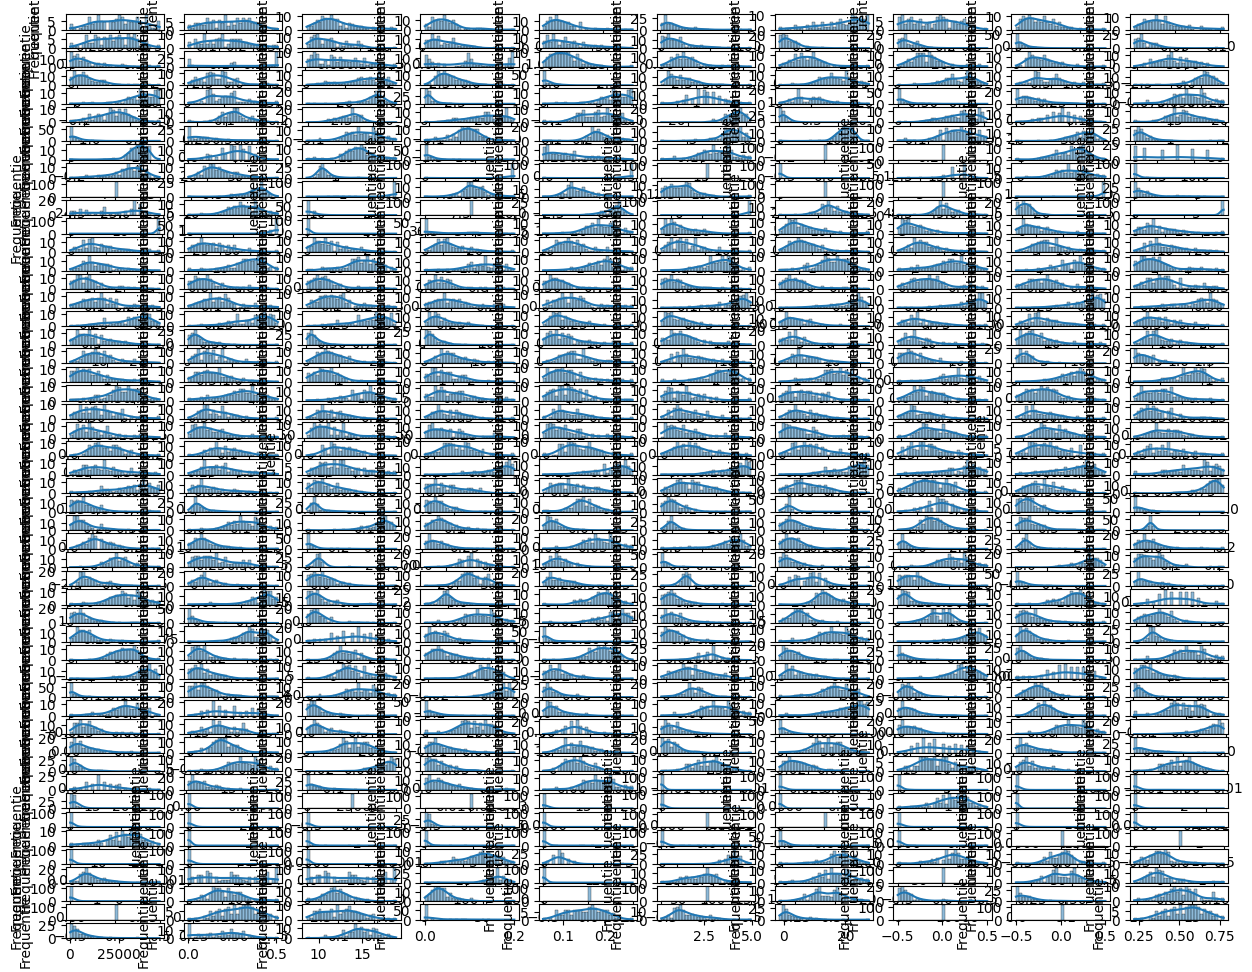

In [5]:
num_cols = features.select_dtypes(include=['number']).columns  # Alleen numerieke kolommen
num_features = len(num_cols)  # Aantal numerieke features
print(num_features)
# Instellingen voor het plotten van meerdere histogrammen
plt.figure(figsize=(15, 12))
for i, col in enumerate(num_cols[:494]):  # Eerst 20 kolommen om het overzichtelijk te houden
    plt.subplot(50, 10, i + 1)  # 4 rijen, 5 kolommen per plotpagina
    sns.histplot(data[col], bins=30, kde=True)
    plt.title(col)
    plt.xlabel("")
    plt.ylabel("Frequentie")

plt.tight_layout()
plt.show()

In [49]:
from scipy.stats import shapiro
normal_count = 0
not_normal_count = 0
for col in data:
  stat, p = shapiro(features[col])
  if p > 0.05:
      normal_count += 1
  else:
      not_normal_count += 1
print(normal_count)
print(not_normal_count)
# dus we kiezen voor normalization want data is voor veel features niet normaal verdeeld

66
427


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


In [53]:
# scaling
scaler = preprocessing.MinMaxScaler()